In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit, jacobian
from jax import random
from jax import vmap

from jax.experimental import ode

import scipy.linalg as sl
import scipy.integrate as si
import scipy.optimize as so

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# simple harmonic oscillator d = 2
# works with both vectorized and standard usage, i.e., 
# when x is of dimension 2 x k, output is of dimension 2 x k
# when x is of dimension 2, output is of dimension 2
# theta = (sigma, rho, beta)

# for autograd to work, there has to be only one positional input, z
# z is a 1-dim array and so is the output

# think of x[0] or z[0] as time
def oscG(z):
    x = z[0:3]
    theta = z[3:]
    fx = x[2]
    fy = -(theta[0] + theta[1]*np.cos(x[0]))*x[1]
    return np.array([fx,fy])

# hand-coded gradient
def mygradoscG(z):
    x = z[0:3]
    theta = z[3:]
    return np.array([[0., 0., 1., 0., 0.],[np.sin(x[0])*theta[1]*x[1], -(theta[0] + theta[1]*np.cos(x[0])), 0., -x[1], -np.cos(x[0])*x[1]]])


In [3]:
# just-in-time (JIT) compiled version
foscG = jit(oscG)
fmygradoscG = jit(mygradoscG)

In [4]:
# using automatic differentiation composed with JIT
gradosc = jacobian(oscG)
fgradosc = jit(gradosc)

In [5]:
# using automatic differentiation
gradosc(np.array([0.,134.,-211.,0.5,0.5]))

/home/hbhat/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray([[   0.,    0.,    1.,    0.,    0.],
             [   0.,   -1.,    0., -134., -134.]], dtype=float64)

In [6]:
# hand-coded gradient
mygradoscG(np.array([0.,134.,-211.,0.5,0.5]))

DeviceArray([[   0.,    0.,    1.,    0.,    0.],
             [   0.,   -1.,    0., -134., -134.]], dtype=float64)

In [7]:
# generate data using ground truth values
x0 = np.array([[1.,0.]])
theta0 = np.array([[0.5,0.5]]).T
t0 = 0.
tf = 2*np.pi
npts = 200
tint = np.linspace(t0, tf, num=npts)
dt = (tf-t0)/(npts-1)

def oscI(t,y):
    ncols = y.shape[1]
    onemat = np.ones((1,ncols))
    trep = t*onemat
    theta0rep = np.matmul(theta0,onemat)
    return oscG(np.vstack([trep,y,theta0rep]))
    
foscI = jit(oscI)

sol = si.solve_ivp(foscI, t_span=(t0,tf+1e-6), 
                   rtol=1e-9, atol=1e-9, y0=x0[0,:], t_eval=tint, vectorized=True)

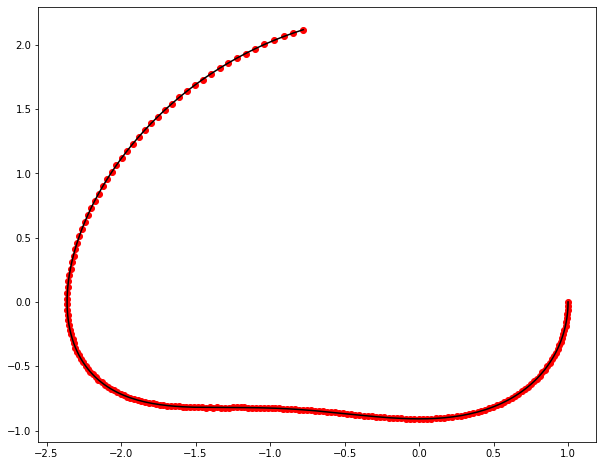

In [8]:
# add mean zero Gaussian noise
xtrue = sol.y
d = 2
key = random.PRNGKey(0)
y = xtrue + 1e-3*random.normal(key, (d, npts))

plt.figure(figsize=(10,8))
plt.plot(xtrue[0,:],xtrue[1,:],color='black')
plt.scatter(y[0,:],y[1,:],color='red')
plt.show()


In [17]:
# # block of code to illustrate timing

# from jax.experimental import ode

# thetatest = np.array([0.4, 0.6])

# fadj = lambda y, t: -np.matmul(y, mygradoscG(np.concatenate([np.array([t]),y,0.3 + 0.5*thetatest]))[:,1:(d+1)])
# icmat = np.eye(d)
# adjtint = np.array([0, dt])
# def solonce(y0):
#     adjsol = ode.odeint(fadj, t=adjtint, rtol=1e-9, atol=1e-9, y0=y0)
#     return adjsol[1,:]

# solmany = jit(lambda yy: vmap(solonce, in_axes=(0))(yy))

# %timeit solmany(0.7 + 0.5*icmat)

# # 1.25 ms ± 89.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

# # find the fundamental solution or propagator of the adjoint ODE over the time period dt
# fadj = lambda t, y: -np.matmul(y, mygradoscG(np.concatenate([np.array([t]),y,0.3 + 0.5*thetatest]))[:,1:(d+1)])
# # fadjvect = jit(lambda t, yy: vmap(fadj, in_axes=(None, 0))(t, yy.T).T)

# adjtint = np.array([0, dt])
# icmat = 0.7 + 0.5*np.eye(d)

# def oldsolmany():
#     proplist = []
#     for i in range(d):
#         adjsol = si.solve_ivp(fadj, t_span=(0, dt + 1e-6), rtol=1e-9, atol=1e-9, y0=icmat[i,:], 
#                               t_eval=adjtint, vectorized=False)
#         proplist.append(adjsol.y[:,1])

#     return np.stack(proplist)

# %timeit oldsolmany()

# # 1.27 s ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
# for scipy.optimize
# z should have (xinit, curtheta)
# note that the t variable is **not** passed in as z[0]
def newlagwithgrad(z):
    xinit = z[0:d]
    curtheta = z[d:]
    
    # solves the forward ODE using our current estimates of xinit and curtheta
    foscI = jit(lambda y, t: oscG(np.concatenate([np.array([t]), y, curtheta])))
    x = ode.odeint(foscI, t=tint, rtol=1e-9, atol=1e-9, y0=xinit).T
    
    # set up adjoint ODE
    fadj = jit(lambda y, t: -np.matmul(y, mygradoscG(np.concatenate([np.array([t]),y,curtheta]))[:,1:(d+1)]))
    icmat = np.eye(d)
    adjtint = np.array([0, dt])
    
    # function that solves the adjoint ODE once for one initial condition
    def solonce(y0):
        adjsol = ode.odeint(fadj, t=adjtint, rtol=1e-9, atol=1e-9, y0=y0)
        return adjsol[1,:]
    
    # this is to solve the adjoint ODE for all initial conditions in the icmat **at once**
    propagator = vmap(jit(solonce), in_axes=(0))(icmat)
    backprop = np.linalg.inv(propagator)
    
    lambminuslist = []
    lambpluslist = []
    lambminuslist.append(y[:, (npts-1)] - x[:, (npts-1)])
    for i in range(npts-1):
        lambpluslist.append(np.matmul(lambminuslist[i], backprop))
        if (i==(npts-2)):
            lambminuslist.append(lambpluslist[i])
        else:
            lambminuslist.append(lambpluslist[i] + y[:, (npts-2-i)] - x[:, (npts-2-i)])
    
    # compute current value of lagrangian
    lag = 0.0
    for i in range(npts-1):
        if i==0:
            xdot = (x[:,i+1]-x[:,i])/(dt)
        elif i==(npts-2):
            xdot = (x[:,i]-x[:,i-1])/(dt)
        else:
            xdot = (x[:,i+1]-x[:,i-1])/(2*dt)
        f = foscG(np.concatenate([np.array([tint[i]]),x[:, i], curtheta]))
        lag += np.dot(lambminuslist[npts-1-i], xdot-f)*dt
        
    lag += np.sum(np.square(x - y))/2.0
    
    # compute gradients using lamb (solution of adjoint ODE)
    # gradient of L with respect to parameters theta
    gradtheta = np.zeros(2)
    for i in range(npts-1):
        g = fmygradoscG(np.concatenate([np.array([tint[i]]),x[:, i], curtheta]))[:,(d+1):]    # nabla_theta f
        gradtheta += -np.matmul(lambminuslist[npts-1-i],g)*dt

    # gradient of L with respect to initial condition x0
    gradx0 = -(y[:,0] - x[:,0] + lambpluslist[npts-2])
    
    return lag, np.concatenate([gradx0, gradtheta])

In [11]:
lagwithgrad = jit(newlagwithgrad)

In [13]:
# adjoint solver with GD (gradient descent)

GTtheta0 = np.array([0.5, 0.5])
GTx0 = xtrue[:,0]
GTz0 = np.concatenate([GTx0, GTtheta0])
print(lagwithgrad(GTz0))

# take as initial guess x = y + noise
theta0 = np.array([0.4, 0.1])
x0 = y[:,0] + 0.1*random.normal(key,(2,))
z0 = np.concatenate([x0, theta0])

maxiters = 1000
step = 1e-4
z = z0.copy()

# train/optimize using simple gradient descent
for i in range(maxiters):
    lag, gradlag = lagwithgrad(z)
    print("iteration " + str(i) + " ; z = " + str(z) + " ; lag = " + str(lag) + " ; gradlag = " + str(gradlag))
    z -= step*gradlag


(DeviceArray(0.00017865, dtype=float64), DeviceArray([-0.00666348,  0.01408011, -0.00841901, -0.0116716 ], dtype=float64))
(DeviceArray(52.01219019, dtype=float64), DeviceArray([ -79.73237994,   37.88911789,  -41.81347043, -188.26819509],            dtype=float64))
iteration 0 ; z = [ 1.18206731 -0.07576032  0.4         0.1       ] ; lag = 52.01219018690815 ; gradlag = [ -79.73237994   37.88911789  -41.81347043 -188.26819509]
iteration 1 ; z = [ 1.19004055 -0.07954924  0.40418135  0.11882682] ; lag = 45.66530616249105 ; gradlag = [ -74.04864896   24.5130491   -12.39253936 -175.03194734]
iteration 2 ; z = [ 1.19744541 -0.08200054  0.4054206   0.13633001] ; lag = 40.333002529985045 ; gradlag = [ -68.37773207   16.41966661    3.52929779 -163.98418112]
iteration 3 ; z = [ 1.20428319 -0.08364251  0.40506767  0.15272843] ; lag = 35.68510397627259 ; gradlag = [ -62.93484091   11.50388072   11.14325353 -154.24374691]
iteration 4 ; z = [ 1.21057667 -0.0847929   0.40395335  0.16815281] ; lag = 3